In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset

import argparse
import matplotlib.pyplot as plt
import numpy as np
import copy


In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:06<00:00, 27.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# train_transform = transforms.Compose([
#             transforms.RandomRotation(20),
#             transforms.RandomHorizontalFlip(0.5),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]), 
#         ])
train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]), 
        ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]), 
    ])

    # Load the original datasets
full_train_set = torchvision.datasets.ImageFolder(root='/home/csgrad/dl_228/tiny-imagenet-200/train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root='/home/csgrad/dl_228/tiny-imagenet-200/val', transform=test_transform)
# test_dataset = torchvision.datasets.ImageFolder(root='/home/csgrad/dl_228/tiny-imagenet-200/test', transform=test_transform)


In [9]:
class_counts = {i:0 for i in range(200)}
max_samples_per_class = 100

selected_indices=[]
for idx, label in enumerate(full_train_set.targets):
  if class_counts[label]<max_samples_per_class:
    selected_indices.append(idx)
    class_counts[label]+=1
  if all(count == max_samples_per_class for count in class_counts.values()):
    break

train_set = Subset(full_train_set, selected_indices)

In [10]:
B = 128 #batch size
lr = 0.001 #learning rate
epochs = 50 #number of epochs

In [11]:
train_loader = DataLoader(train_set, batch_size=B, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=B, shuffle=False, num_workers=2)

In [12]:
print(f"Total train_samples: {len(train_set)}")
print(f"Total test_samples: {len(test_set)}")

Total train_samples: 20000
Total test_samples: 5000


In [ ]:

device='cuda' if torch.cuda.is_available() else 'cpu'
device

In [14]:
model = torchvision.models.resnet18(weights=None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs, device):

    epoch_loss=[]
    epoch_acc=[]
    test_acc=[]
    best_acc=0.0
    best_model_state = None

    for epoch in range(epochs):
      print()
      # print('-'*50)
      # print(f"Epoch: {epoch+1}/{epochs}")
      # print('-'*50)
      running_loss=0.0
      running_corrects=0

      model.train()
      total_labels=0
      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        running_corrects+=predicted.eq(labels).sum().item()
        total_labels += len(labels)

      epoch_loss.append(running_loss/len(labels))
      epoch_acc.append(running_corrects/total_labels)

      #evaluate on test set
      model.eval()
      # test_loss=0.0
      test_corrects=0
      total_labels=0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs=model(inputs)
          loss= criterion(outputs, labels)
          # test_loss+=loss.item()
          _,predicted=outputs.max(1)
          test_corrects+=predicted.eq(labels).sum().item()
          total_labels += len(labels)

        test_acc.append(test_corrects/total_labels)

      print(f"Epoch: {epoch+1}, Loss: {epoch_loss[-1]:.4f}, Train Acc: {epoch_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

      if test_acc[-1]>best_acc:
        best_acc=test_acc[-1]
        # torch.save(model.state_dict(), 'best_model.pth')
        best_model_state = model.state_dict()
        print(f"Best model state stored with accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model, epoch_loss, epoch_acc, test_acc

# def evaluate_model(model, test_loader):
#     model.eval()
#     running_corrects = 0

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             running_corrects += torch.sum(preds == labels.data)

#     print("Final Test Accuracy")



model, train_loss_vanilla, train_acc_vanilla, test_acc_vanilla = train_model(model,  criterion, optimizer, train_loader, test_loader, epochs, device)
# evaluate_model(model, test_loader)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_vanilla, label='Train Loss', color='blue')
# plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_vanilla, label='Train Accuracy', color='blue')
plt.plot(test_acc_vanilla, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Epoch: 1, Loss: 24.8340, Train Acc: 0.0327, Test Acc: 0.0550
Best model state stored with accuracy: 0.0550

Epoch: 2, Loss: 21.7712, Train Acc: 0.0791, Test Acc: 0.0844
Best model state stored with accuracy: 0.0844

Epoch: 3, Loss: 19.6856, Train Acc: 0.1300, Test Acc: 0.1124
Best model state stored with accuracy: 0.1124

Epoch: 4, Loss: 17.9042, Train Acc: 0.1809, Test Acc: 0.1512
Best model state stored with accuracy: 0.1512

Epoch: 5, Loss: 16.1414, Train Acc: 0.2413, Test Acc: 0.1704
Best model state stored with accuracy: 0.1704

Epoch: 6, Loss: 14.3103, Train Acc: 0.3048, Test Acc: 0.1666

Epoch: 7, Loss: 12.0386, Train Acc: 0.3881, Test Acc: 0.1782
Best model state stored with accuracy: 0.1782

Epoch: 8, Loss: 9.2495, Train Acc: 0.5154, Test Acc: 0.1656

Epoch: 9, Loss: 5.8531, Train Acc: 0.6884, Test Acc: 0.1804
Best model state stored with accuracy: 0.1804

Epoch: 10, Loss: 2.7236, Train Acc: 0.8625, Test Acc: 0.1680

Epoch: 11, Loss: 1.0105, Train Acc: 0.9601, Test Acc: 0.1820

KeyboardInterrupt: 

**Question 2: Mixup Augmentation**

In [10]:
#data augmentation
def mixup_aug(train_set, alpha=1.0):
    # Split the dataset into two halves
    print(f"len train_set={len(train_set)}")
    split_ratio = 0.5
    split_size_1 = int(len(train_set) * split_ratio)
    split_size_2 = len(train_set) - split_size_1

    dataset_1, dataset_2 = random_split(train_set, [split_size_1, split_size_2])
    print(f"len dataset_1={len(dataset_1)}")
    print(f"len dataset_2={len(dataset_2)}")

    # Create DataLoaders for the two datasets
    train_loader_1 = DataLoader(dataset_1, batch_size=B, shuffle=True)
    train_loader_2 = DataLoader(dataset_2, batch_size=B, shuffle=True)

    return train_loader_1, train_loader_2


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


len train_set=10000
len dataset_1=5000
len dataset_2=5000
****************************************************************************************************
Alpha: 0.2

Epoch: 1, Loss: 12.3806, Train Acc: 0.1436, Test Acc: 0.3327
Best model state stored with accuracy: 0.3327

Epoch: 2, Loss: 8.7361, Train Acc: 0.1926, Test Acc: 0.4140
Best model state stored with accuracy: 0.4140

Epoch: 3, Loss: 8.5386, Train Acc: 0.2009, Test Acc: 0.4387
Best model state stored with accuracy: 0.4387

Epoch: 4, Loss: 7.8775, Train Acc: 0.2293, Test Acc: 0.4388
Best model state stored with accuracy: 0.4388

Epoch: 5, Loss: 7.3443, Train Acc: 0.2490, Test Acc: 0.4733
Best model state stored with accuracy: 0.4733

Epoch: 6, Loss: 6.9747, Train Acc: 0.2666, Test Acc: 0.5188
Best model state stored with accuracy: 0.5188

Epoch: 7, Loss: 6.9407, Train Acc: 0.2689, Test Acc: 0.5222
Best model state stored with accuracy: 0.5222

Epoch: 8, Loss: 6.9595, Train Acc: 0.2744, Test Acc: 0.5334
Best model state st

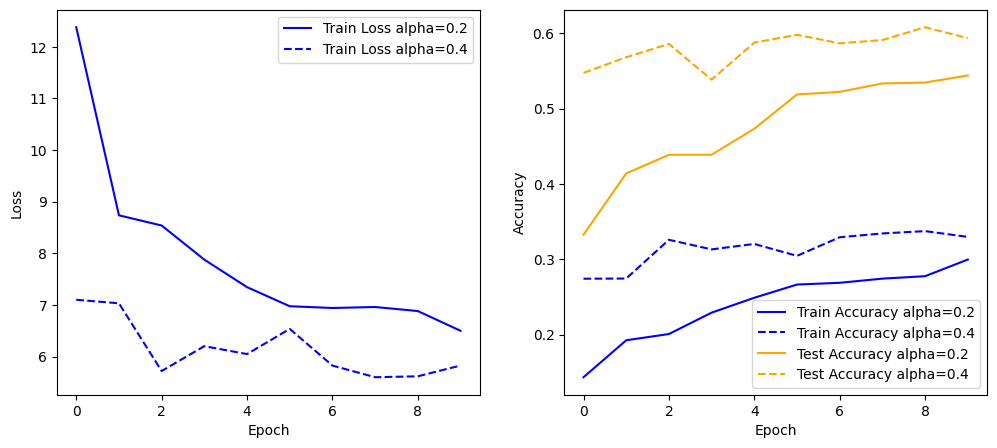

In [11]:
model = torchvision.models.resnet18(weights=None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

def train_model_mixup(model, criterion, optimizer, train_loader_1, train_loader_2, test_loader, epochs, device, alpha=1.0):

    epoch_loss=[]
    epoch_acc=[]
    test_acc=[]
    best_acc=0.0
    best_model_state = None

    for epoch in range(epochs):
      print()

      running_loss=0.0
      running_corrects=0

      model.train()
      total_labels=0

      for (x1,y1),(x2,y2) in zip(train_loader_1, train_loader_2):
        x1, y1 = x1.to(device), y1.to(device)
        x2, y2 = x2.to(device), y2.to(device)
        lambda_val = np.random.beta(alpha, alpha)
        x = lambda_val * x1 + (1 - lambda_val) * x2
        y_a, y_b = y1, y2

        optimizer.zero_grad()
        outputs=model(x)
        loss= mixup_criterion(criterion, outputs, y_a, y_b, lambda_val)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        running_corrects += (lambda_val * predicted.eq(y_a).sum().item()
                    + (1 - lambda_val) * predicted.eq(y_b).sum().item())
        total_labels += len(y_a)+len(y_b)

      epoch_loss.append(running_loss/x1.shape[0])
      epoch_acc.append(running_corrects/total_labels)

      #evaluate on test set
      model.eval()
      # test_loss=0.0
      test_corrects=0
      total_labels=0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs=model(inputs)
          loss= criterion(outputs, labels)
          _,predicted=outputs.max(1)
          test_corrects+=predicted.eq(labels).sum().item()
          total_labels += len(labels)

        test_acc.append(test_corrects/total_labels)

      print(f"Epoch: {epoch+1}, Loss: {epoch_loss[-1]:.4f}, Train Acc: {epoch_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

      if test_acc[-1]>best_acc:
        best_acc=test_acc[-1]
        best_model_state = model.state_dict()
        print(f"Best model state stored with accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model, epoch_loss, epoch_acc, test_acc




train_loader_1, train_loader_2 = mixup_aug(train_set, alpha=1.0)
alpha_set=[0.2, 0.4]
train_loss_alpha=[]
test_acc_alpha = []
train_acc_alpha=[]

for alpha in alpha_set:
  print('*'*100)
  print(f"Alpha: {alpha}")
  model, train_loss, train_acc, test_acc = train_model_mixup(model,  criterion, optimizer, train_loader_1, train_loader_2, test_loader, epochs, device, alpha)
  # evaluate_model(model, test_loader)
  train_loss_alpha.append(train_loss)
  test_acc_alpha.append(test_acc)
  train_acc_alpha.append(train_acc)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_alpha[0], label='Train Loss alpha=0.2', color='blue')
plt.plot(train_loss_alpha[1], label='Train Loss alpha=0.4', color='blue', linestyle='--')
# plt.plot(train_loss, label='Train Loss', color='blue')
# plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_alpha[0], label='Train Accuracy alpha=0.2', color='blue')
plt.plot(train_acc_alpha[1], label='Train Accuracy alpha=0.4', color='blue', linestyle='--')
plt.plot(test_acc_alpha[0], label='Test Accuracy alpha=0.2', color='orange')
plt.plot(test_acc_alpha[1], label='Test Accuracy alpha=0.4', color='orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



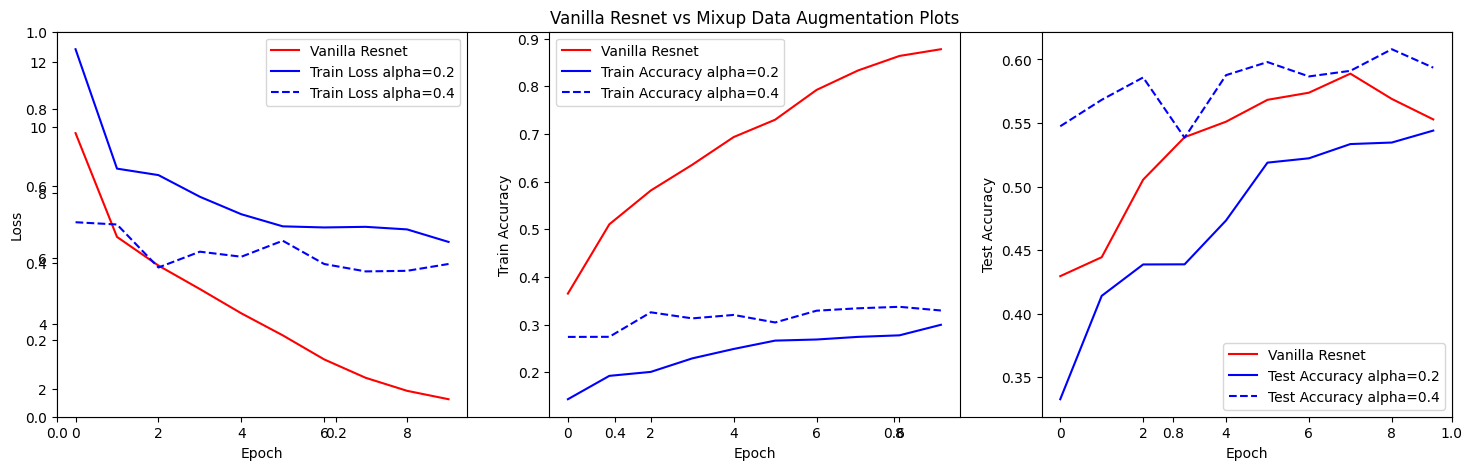

In [12]:

plt.figure(figsize=(18, 5))
plt.title("Vanilla Resnet vs Mixup Data Augmentation Plots")

plt.subplot(1, 3, 1)
plt.plot(train_loss_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_loss_alpha[0], label='Train Loss alpha=0.2', color='blue')
plt.plot(train_loss_alpha[1], label='Train Loss alpha=0.4', color='blue', linestyle='--')
# plt.plot(train_loss, label='Train Loss', color='blue')
# plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_acc_alpha[0], label='Train Accuracy alpha=0.2', color='blue')
plt.plot(train_acc_alpha[1], label='Train Accuracy alpha=0.4', color='blue', linestyle='--')
# plt.plot(train_acc_alpha[0], label='Test Accuracy alpha=0.2', color='orange')
# plt.plot(train_acc_alpha[1], label='Test Accuracy alpha=0.4', color='orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_acc_vanilla, label='Vanilla Resnet', color='red')
# plt.plot(train_acc_alpha[0], label='Train Accuracy alpha=0.2', color='blue')
# plt.plot(test_acc_alpha[1], label='Train Accuracy alpha=0.4', color='blue', linestyle='--')
plt.plot(test_acc_alpha[0], label='Test Accuracy alpha=0.2', color='blue')
plt.plot(test_acc_alpha[1], label='Test Accuracy alpha=0.4', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()



**3. Question 3 - Cutout Augmentation**

In [13]:
#data augmentation

def cutout_image(image, K):
    _, height, width = image.shape
    center_x = np.random.randint(0, width)
    center_y = np.random.randint(0, height)

    x1 = max(0, center_x - K)
    x2 = min(width, center_x + K)
    y1 = max(0, center_y - K)
    y2 = min(height, center_y + K)
    image[:, y1:y2, x1:x2] = 0

    return image


def cutout_aug(image, p=0.5, K=4):
    prob_curr = torch.rand(1).item()
    if prob_curr > p:
        return image
    else:
        return cutout_image(image, K)




****************************************************************************************************

Epoch: 1, Loss: 10.8032, Train Acc: 0.2822, Test Acc: 0.3784
Best model state stored with accuracy: 0.3784

Epoch: 2, Loss: 8.4477, Train Acc: 0.3691, Test Acc: 0.4140
Best model state stored with accuracy: 0.4140

Epoch: 3, Loss: 7.8902, Train Acc: 0.4185, Test Acc: 0.4546
Best model state stored with accuracy: 0.4546

Epoch: 4, Loss: 7.4038, Train Acc: 0.4516, Test Acc: 0.4963
Best model state stored with accuracy: 0.4963

Epoch: 5, Loss: 6.9648, Train Acc: 0.4894, Test Acc: 0.5110
Best model state stored with accuracy: 0.5110

Epoch: 6, Loss: 6.7468, Train Acc: 0.5091, Test Acc: 0.5428
Best model state stored with accuracy: 0.5428

Epoch: 7, Loss: 6.6197, Train Acc: 0.5209, Test Acc: 0.5583
Best model state stored with accuracy: 0.5583

Epoch: 8, Loss: 6.1208, Train Acc: 0.5533, Test Acc: 0.5198

Epoch: 9, Loss: 5.8645, Train Acc: 0.5744, Test Acc: 0.6010
Best model state stored wit

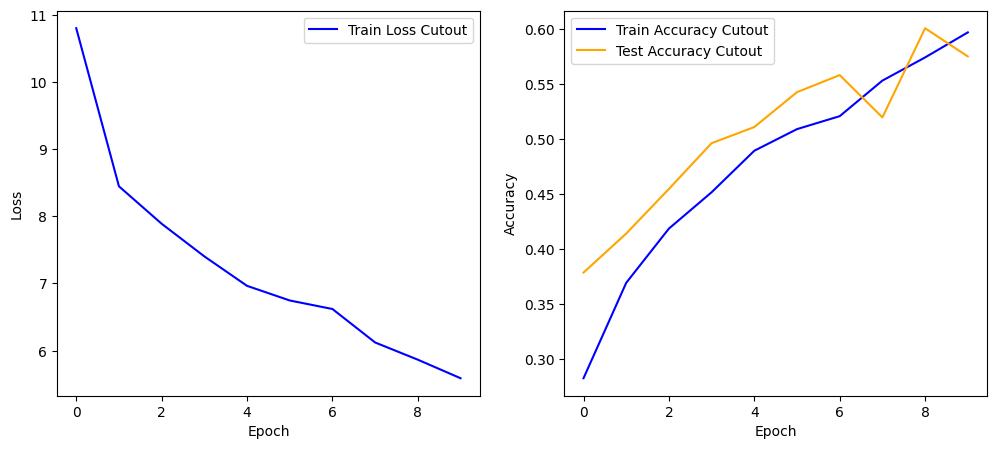

In [14]:
model = torchvision.models.resnet18(weights=None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

def train_model_cutout(model, criterion, optimizer, train_loader, test_loader, epochs, device, K=16, p=0.5):

    epoch_loss=[]
    epoch_acc=[]
    test_acc=[]
    best_acc=0.0
    best_model_state = None

    for epoch in range(epochs):
      print()
      # print('-'*50)
      # print(f"Epoch: {epoch+1}/{epochs}")
      # print('-'*50)
      running_loss=0.0
      running_corrects=0

      model.train()
      total_labels=0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = torch.stack([cutout_aug(img, p=p, K=K) for img in inputs])
        optimizer.zero_grad()
        outputs=model(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        running_corrects += predicted.eq(labels).sum().item()
        total_labels += len(labels)

      epoch_loss.append(running_loss/inputs.shape[0])
      epoch_acc.append(running_corrects/total_labels)

      #evaluate on test set
      model.eval()
      # test_loss=0.0
      test_corrects=0
      total_labels=0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs=model(inputs)
          loss= criterion(outputs, labels)
          _,predicted=outputs.max(1)
          test_corrects+=predicted.eq(labels).sum().item()
          total_labels += len(labels)

        test_acc.append(test_corrects/total_labels)

      print(f"Epoch: {epoch+1}, Loss: {epoch_loss[-1]:.4f}, Train Acc: {epoch_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

      if test_acc[-1]>best_acc:
        best_acc=test_acc[-1]
        best_model_state = model.state_dict()
        print(f"Best model state stored with accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model, epoch_loss, epoch_acc, test_acc



K=16
p=0.5

print('*'*100)
model, train_loss_cutout, train_acc_cutout, test_acc_cutout = train_model_cutout(model,  criterion, optimizer, train_loader, test_loader, epochs, device, K, p)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_cutout, label='Train Loss Cutout', color='blue')
# plt.plot(train_loss, label='Train Loss', color='blue')
# plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_cutout, label='Train Accuracy Cutout', color='blue')
plt.plot(test_acc_cutout, label='Test Accuracy Cutout', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



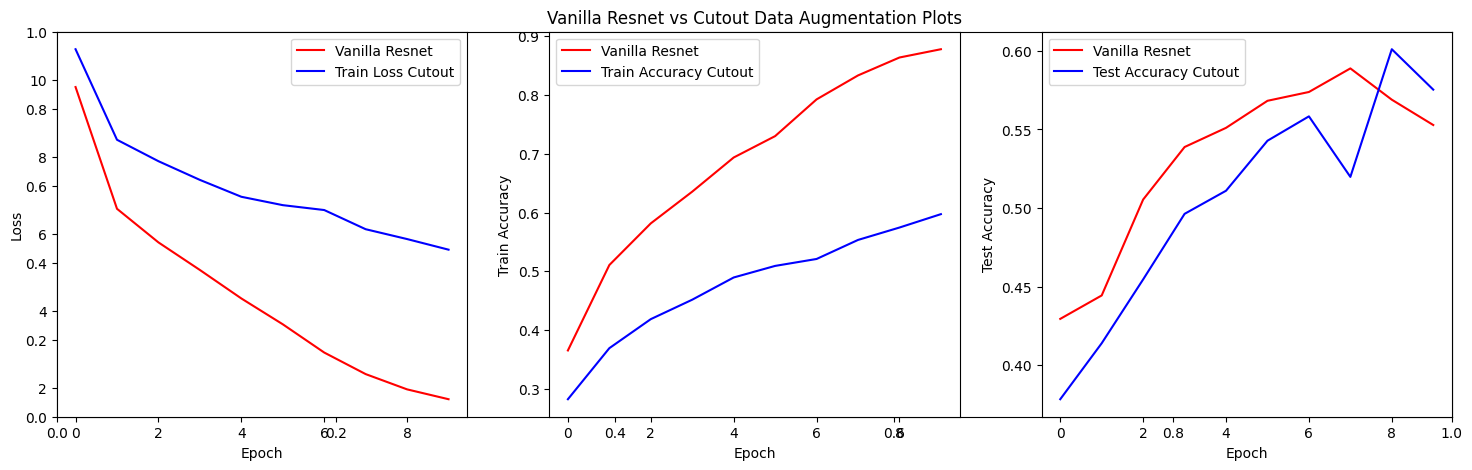

In [15]:

plt.figure(figsize=(18, 5))
plt.title("Vanilla Resnet vs Cutout Data Augmentation Plots")

plt.subplot(1, 3, 1)
plt.plot(train_loss_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_loss_cutout, label='Train Loss Cutout', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_acc_cutout, label='Train Accuracy Cutout', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_acc_vanilla, label='Vanilla Resnet', color='red')
plt.plot(test_acc_cutout, label='Test Accuracy Cutout', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()



**Question 4 - Standard Augmentation**

In [16]:
#data augmentation

def standard_augmentation(image, K=4, p=0.5):
    _, height, width = image.shape

    k1 = np.random.randint(-K, K + 1)  # Vertical shift
    k2 = np.random.randint(-K, K + 1)  # Horizontal shift

    # Apply zero padding and shift
    padded_image = torch.zeros_like(image)  # Create a zero-padded image
    y1, y2 = max(0, k1), min(height, height + k1)  # Vertical bounds
    x1, x2 = max(0, k2), min(width, width + k2)  # Horizontal bounds
    py1, py2 = max(0, -k1), min(height, height - k1)  # Padded vertical bounds
    px1, px2 = max(0, -k2), min(width, width - k2)  # Padded horizontal bounds

    padded_image[:, y1:y2, x1:x2] = image[:, py1:py2, px1:px2]  # Apply shift

    # Apply horizontal flip with 50% probability
    if torch.rand(1).item() > p:
        padded_image = torch.flip(padded_image, dims=[2])  # Flip along width

    return padded_image




****************************************************************************************************

Epoch: 1, Loss: 10.1553, Train Acc: 0.3293, Test Acc: 0.3859
Best model state stored with accuracy: 0.3859

Epoch: 2, Loss: 7.7570, Train Acc: 0.4208, Test Acc: 0.4085
Best model state stored with accuracy: 0.4085

Epoch: 3, Loss: 7.1924, Train Acc: 0.4673, Test Acc: 0.4724
Best model state stored with accuracy: 0.4724

Epoch: 4, Loss: 6.6627, Train Acc: 0.5102, Test Acc: 0.5008
Best model state stored with accuracy: 0.5008

Epoch: 5, Loss: 6.2264, Train Acc: 0.5410, Test Acc: 0.5139
Best model state stored with accuracy: 0.5139

Epoch: 6, Loss: 5.8519, Train Acc: 0.5754, Test Acc: 0.5017

Epoch: 7, Loss: 5.6013, Train Acc: 0.5990, Test Acc: 0.5856
Best model state stored with accuracy: 0.5856

Epoch: 8, Loss: 5.2850, Train Acc: 0.6210, Test Acc: 0.5647

Epoch: 9, Loss: 4.9631, Train Acc: 0.6404, Test Acc: 0.6323
Best model state stored with accuracy: 0.6323

Epoch: 10, Loss: 4.8633, T

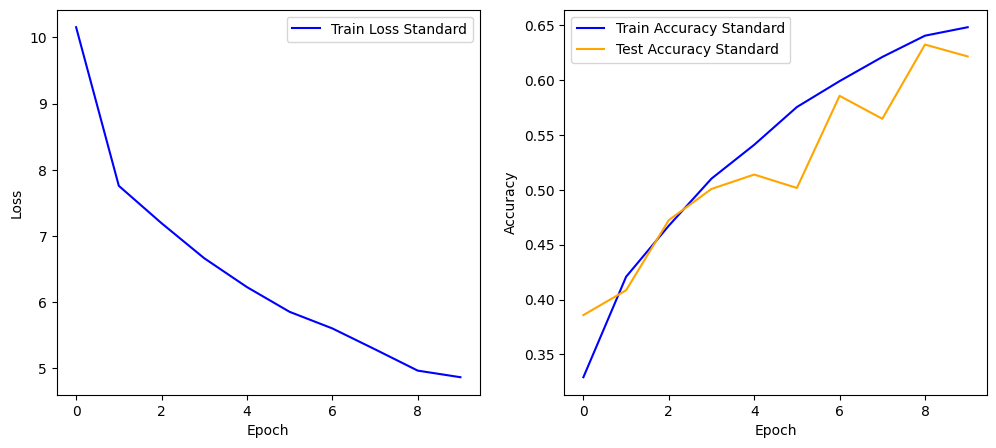

In [17]:
model = torchvision.models.resnet18(weights=None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

def train_model_standard(model, criterion, optimizer, train_loader, test_loader, epochs, device, K=4, p=0.5):

    epoch_loss=[]
    epoch_acc=[]
    test_acc=[]
    best_acc=0.0
    best_model_state = None

    for epoch in range(epochs):
      print()
      # print('-'*50)
      # print(f"Epoch: {epoch+1}/{epochs}")
      # print('-'*50)
      running_loss=0.0
      running_corrects=0

      model.train()
      total_labels=0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = torch.stack([standard_augmentation(img, K=K, p=p) for img in inputs])
        optimizer.zero_grad()
        outputs=model(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        running_corrects += predicted.eq(labels).sum().item()
        total_labels += len(labels)

      epoch_loss.append(running_loss/inputs.shape[0])
      epoch_acc.append(running_corrects/total_labels)

      #evaluate on test set
      model.eval()
      # test_loss=0.0
      test_corrects=0
      total_labels=0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs=model(inputs)
          loss= criterion(outputs, labels)
          _,predicted=outputs.max(1)
          test_corrects+=predicted.eq(labels).sum().item()
          total_labels += len(labels)

        test_acc.append(test_corrects/total_labels)

      print(f"Epoch: {epoch+1}, Loss: {epoch_loss[-1]:.4f}, Train Acc: {epoch_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

      if test_acc[-1]>best_acc:
        best_acc=test_acc[-1]
        best_model_state = model.state_dict()
        print(f"Best model state stored with accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model, epoch_loss, epoch_acc, test_acc



K=4
p=0.5

print('*'*100)
model, train_loss_standard, train_acc_standard, test_acc_standard = train_model_standard(model,  criterion, optimizer, train_loader, test_loader, epochs, device, K, p)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_standard, label='Train Loss Standard', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_standard, label='Train Accuracy Standard', color='blue')
plt.plot(test_acc_standard, label='Test Accuracy Standard', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



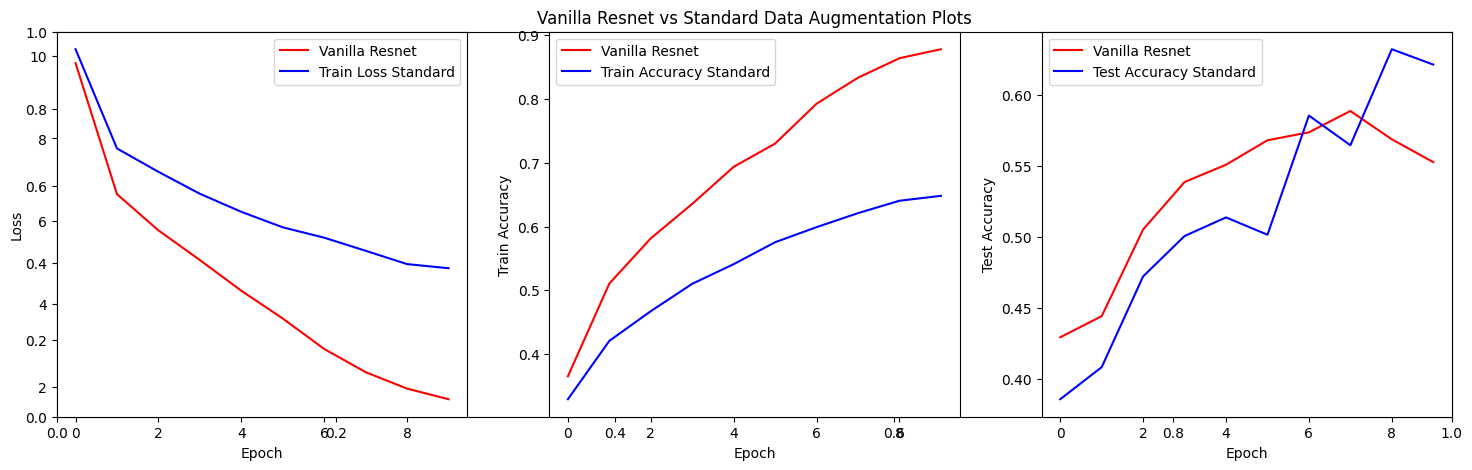

In [18]:

plt.figure(figsize=(18, 5))
plt.title("Vanilla Resnet vs Standard Data Augmentation Plots")

plt.subplot(1, 3, 1)
plt.plot(train_loss_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_loss_standard, label='Train Loss Standard', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_acc_standard, label='Train Accuracy Standard', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_acc_vanilla, label='Vanilla Resnet', color='red')
plt.plot(test_acc_standard, label='Test Accuracy Standard', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()



**Question 5 - Mixup, Cutout and Standard Augmentation Together**

In [16]:
#data augmentation

def standard_augmentation(image, K=4, p=0.5):
    _, height, width = image.shape

    k1 = np.random.randint(-K, K + 1)  # Vertical shift
    k2 = np.random.randint(-K, K + 1)  # Horizontal shift

    # Apply zero padding and shift
    padded_image = torch.zeros_like(image)  # Create a zero-padded image
    y1, y2 = max(0, k1), min(height, height + k1)  # Vertical bounds
    x1, x2 = max(0, k2), min(width, width + k2)  # Horizontal bounds
    py1, py2 = max(0, -k1), min(height, height - k1)  # Padded vertical bounds
    px1, px2 = max(0, -k2), min(width, width - k2)  # Padded horizontal bounds

    padded_image[:, y1:y2, x1:x2] = image[:, py1:py2, px1:px2]  # Apply shift

    # Apply horizontal flip with 50% probability
    if torch.rand(1).item() > p:
        padded_image = torch.flip(padded_image, dims=[2])  # Flip along width

    return padded_image

def cutout_image(image, K):
    _, height, width = image.shape
    center_x = np.random.randint(0, width)
    center_y = np.random.randint(0, height)

    x1 = max(0, center_x - K)
    x2 = min(width, center_x + K)
    y1 = max(0, center_y - K)
    y2 = min(height, center_y + K)
    image[:, y1:y2, x1:x2] = 0

    return image


def cutout_aug(image, p=0.5, K=4):
    prob_curr = torch.rand(1).item()
    if prob_curr > p:
        return image
    else:
        return cutout_image(image, K)


def mixup_aug(train_set, alpha=1.0):
    # Split the dataset into two halves
    print(f"len train_set={len(train_set)}")
    split_ratio = 0.5
    split_size_1 = int(len(train_set) * split_ratio)
    split_size_2 = len(train_set) - split_size_1

    dataset_1, dataset_2 = random_split(train_set, [split_size_1, split_size_2])
    print(f"len dataset_1={len(dataset_1)}")
    print(f"len dataset_2={len(dataset_2)}")

    # Create DataLoaders for the two datasets
    train_loader_1 = DataLoader(dataset_1, batch_size=B, shuffle=True)
    train_loader_2 = DataLoader(dataset_2, batch_size=B, shuffle=True)

    return train_loader_1, train_loader_2


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)




len train_set=10000
len dataset_1=5000
len dataset_2=5000
****************************************************************************************************
Alpha: 0.4

Epoch: 1, Loss: 13.5695, Train Acc: 0.0940, Test Acc: 0.2533
Best model state stored with accuracy: 0.2533

Epoch: 2, Loss: 10.1842, Train Acc: 0.1297, Test Acc: 0.3650
Best model state stored with accuracy: 0.3650

Epoch: 3, Loss: 10.1685, Train Acc: 0.1299, Test Acc: 0.3627

Epoch: 4, Loss: 10.0393, Train Acc: 0.1388, Test Acc: 0.3574

Epoch: 5, Loss: 9.8005, Train Acc: 0.1495, Test Acc: 0.4133
Best model state stored with accuracy: 0.4133

Epoch: 6, Loss: 9.7512, Train Acc: 0.1465, Test Acc: 0.4313
Best model state stored with accuracy: 0.4313

Epoch: 7, Loss: 9.7106, Train Acc: 0.1504, Test Acc: 0.4290

Epoch: 8, Loss: 9.5826, Train Acc: 0.1572, Test Acc: 0.3674

Epoch: 9, Loss: 9.1893, Train Acc: 0.1705, Test Acc: 0.4255

Epoch: 10, Loss: 9.4141, Train Acc: 0.1664, Test Acc: 0.4551
Best model state stored with ac

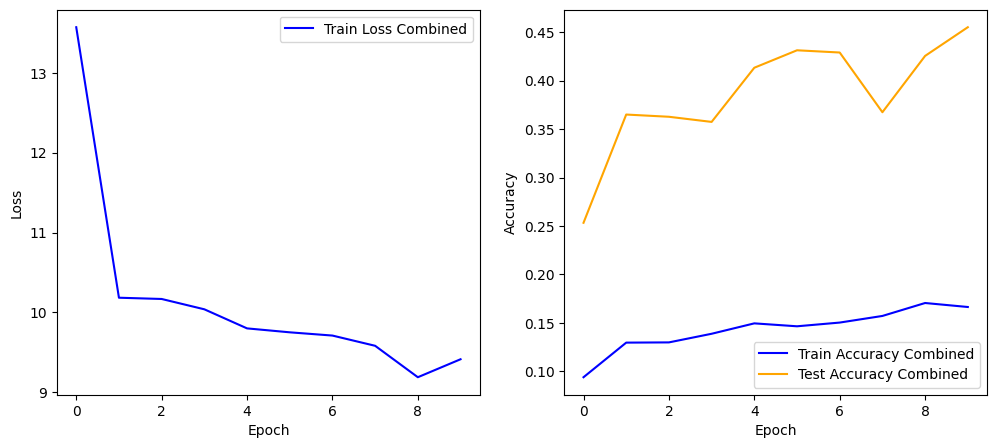

In [20]:
model = torchvision.models.resnet18(weights=None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

def train_model_combined(model, criterion, optimizer, train_loader_1, train_loader_2, test_loader, epochs, device, alpha=1.0, k_cut=16, p_cut=0.5, k_std=4, p_std=0.5):

    epoch_loss=[]
    epoch_acc=[]
    test_acc=[]
    best_acc=0.0
    best_model_state = None

    for epoch in range(epochs):
      print()

      running_loss=0.0
      running_corrects=0

      model.train()
      total_labels=0

      for (x1,y1),(x2,y2) in zip(train_loader_1, train_loader_2):
        x1, y1 = x1.to(device), y1.to(device)
        x2, y2 = x2.to(device), y2.to(device)
        lambda_val = np.random.beta(alpha, alpha)

        x1 = torch.stack([standard_augmentation(img, K=K, p=p) for img in x1])
        x2 = torch.stack([standard_augmentation(img, K=K, p=p) for img in x2])

        x1 = torch.stack([cutout_aug(img, p=0.5, K=16) for img in x1])
        x2 = torch.stack([cutout_aug(img, p=0.5, K=16) for img in x2])

        x = lambda_val * x1 + (1 - lambda_val) * x2
        y_a, y_b = y1, y2

        optimizer.zero_grad()
        outputs=model(x)
        loss= mixup_criterion(criterion, outputs, y_a, y_b, lambda_val)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        running_corrects += (lambda_val * predicted.eq(y_a).sum().item()
                    + (1 - lambda_val) * predicted.eq(y_b).sum().item())
        total_labels += len(y_a)+len(y_b)

      epoch_loss.append(running_loss/x1.shape[0])
      epoch_acc.append(running_corrects/total_labels)

      #evaluate on test set
      model.eval()
      # test_loss=0.0
      test_corrects=0
      total_labels=0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs=model(inputs)
          loss= criterion(outputs, labels)
          _,predicted=outputs.max(1)
          test_corrects+=predicted.eq(labels).sum().item()
          total_labels += len(labels)

        test_acc.append(test_corrects/total_labels)

      print(f"Epoch: {epoch+1}, Loss: {epoch_loss[-1]:.4f}, Train Acc: {epoch_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

      if test_acc[-1]>best_acc:
        best_acc=test_acc[-1]
        best_model_state = model.state_dict()
        print(f"Best model state stored with accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model, epoch_loss, epoch_acc, test_acc


alpha_set=[0.4]
k_cut, p_cut = 16, 0.5
k_std, p_std = 4, 0.5


train_loader_1, train_loader_2 = mixup_aug(train_set, alpha=1.0)

for alpha in alpha_set:
  print('*'*100)
  print(f"Alpha: {alpha}")
  model, train_loss_combined, train_acc_combined, test_acc_combined = train_model_combined(model,  criterion, optimizer, train_loader_1, train_loader_2, test_loader, epochs, device, alpha, k_cut, p_cut, k_std, p_std)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_combined, label='Train Loss Combined', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_combined, label='Train Accuracy Combined', color='blue')
plt.plot(test_acc_combined, label='Test Accuracy Combined', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



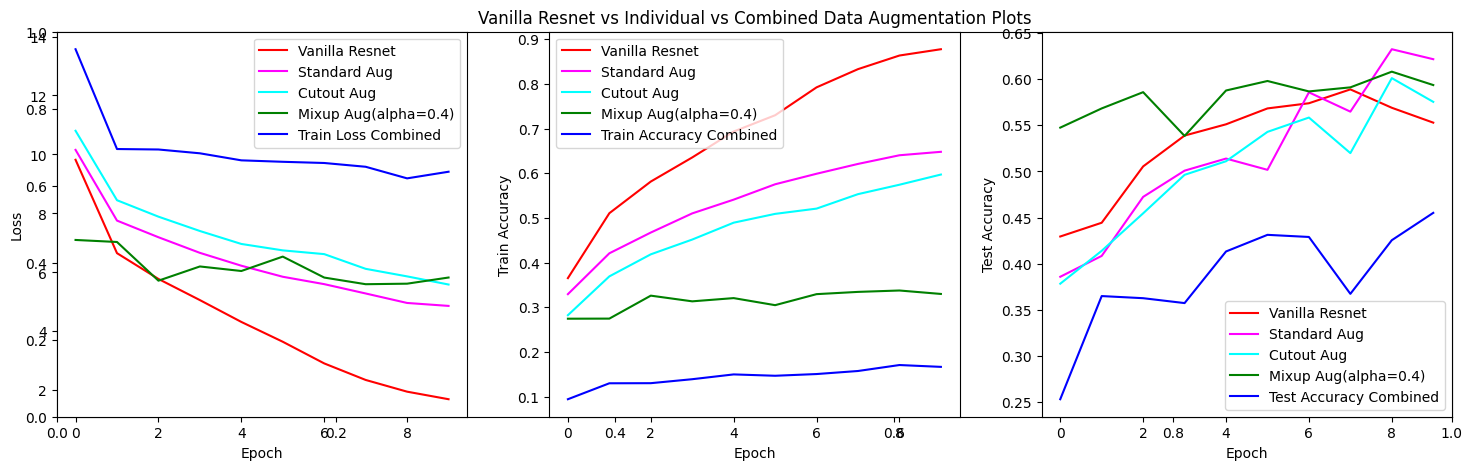

In [21]:

plt.figure(figsize=(18, 5))
plt.title("Vanilla Resnet vs Individual vs Combined Data Augmentation Plots")

plt.subplot(1, 3, 1)
plt.plot(train_loss_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_loss_standard, label='Standard Aug', color='magenta')
plt.plot(train_loss_cutout, label='Cutout Aug', color='cyan')
plt.plot(train_loss_alpha[1], label='Mixup Aug(alpha=0.4)', color='green')
plt.plot(train_loss_combined, label='Train Loss Combined', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_vanilla, label='Vanilla Resnet', color='red')
plt.plot(train_acc_standard, label='Standard Aug', color='magenta')
plt.plot(train_acc_cutout, label='Cutout Aug', color='cyan')
plt.plot(train_acc_alpha[1], label='Mixup Aug(alpha=0.4)', color='green')
plt.plot(train_acc_combined, label='Train Accuracy Combined', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_acc_vanilla, label='Vanilla Resnet', color='red')
plt.plot(test_acc_standard, label='Standard Aug', color='magenta')
plt.plot(test_acc_cutout, label='Cutout Aug', color='cyan')
plt.plot(test_acc_alpha[1], label='Mixup Aug(alpha=0.4)', color='green')
plt.plot(test_acc_combined, label='Test Accuracy Combined', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()



# A. Mixcut Augmentation

In [31]:
#data augmentation
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def mixcut_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [35]:
model = torchvision.models.resnet18(weights=None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

def train_model_cutmix(model, criterion, optimizer, train_loader, test_loader, epochs, device, alpha=1.0, patience=10, min_delta=0.0, p=0.5):

    epoch_loss=[]
    epoch_acc=[]
    test_acc=[]
    test_loss=[]

    best_val_loss = float('inf')
    best_val_acc = float('-inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
      print()

      running_loss=0.0
      running_corrects=0

      model.train()
      total_labels=0

      
      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape[0])
        optimizer.zero_grad()

        r=np.random.rand(1)
        if r<p:
          lambda_val = np.random.beta(alpha, alpha)
          rand_index = torch.randperm(inputs.shape[0]).to(device)
          target_a = labels
          target_b = labels[rand_index]
          bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.shape, lambda_val)
          inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
          # adjust lambda to exactly match pixel ratio
          lambda_val = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.shape[-1] * inputs.shape[-2]))
          outputs=model(inputs)
          loss= mixcut_criterion(criterion, outputs, target_a, target_b, lambda_val)
        else:
           
          outputs=model(inputs)
          loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        if r<p:
          running_corrects += (lambda_val * predicted.eq(target_a).sum().item()
                      + (1 - lambda_val) * predicted.eq(target_b).sum().item())
          total_labels += len(target_a)+len(target_b)
          epoch_loss.append(running_loss/len(train_loader.dataset))
        else:
          running_corrects +=  predicted.eq(labels).sum().item()
          total_labels += len(labels)
          epoch_loss.append(running_loss/len(train_loader.dataset))

      
      epoch_acc.append(running_corrects/total_labels)

      #evaluate on test set
      model.eval()
      # test_loss=0.0
      test_corrects=0
      total_labels=0
      running_loss=0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs=model(inputs)
          loss= criterion(outputs, labels)
          running_loss += loss.item()

          _,predicted=outputs.max(1)
          test_corrects+=predicted.eq(labels).sum().item()
          total_labels += len(labels)

        epoch_test_loss = running_loss / len(test_loader.dataset)
        epoch_test_acc = test_corrects/total_labels
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

      print(f"Epoch: {epoch+1}, Loss: {epoch_loss[-1]:.4f}, Train Acc: {epoch_acc[-1]:.4f},Test Loss:{test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

      # Check for improvement based on val loss
      if epoch_test_loss < best_val_loss - min_delta:
          best_val_loss = epoch_test_loss
          best_acc = epoch_test_acc
          best_model_wts = copy.deepcopy(model.state_dict())
          epochs_no_improve = 0  # Reset counter
      else:
          epochs_no_improve += 1
          print(f"Patience = {epochs_no_improve}/{patience}")

      # Early stopping
      if epochs_no_improve >= patience:
          print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
          break

      #   if test_acc[-1]>best_acc:
      #     best_acc=test_acc[-1]
      #     best_model_state = model.state_dict()
      #     print(f"Best model state stored with accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model, epoch_loss, epoch_acc, test_acc





alpha_set=[0.2, 0.4, 0.6]
train_loss_alpha=[]
test_acc_alpha = []
train_acc_alpha=[]

for alpha in alpha_set:
  print('*'*100)
  print(f"Alpha: {alpha}")
  model, train_loss, train_acc, test_acc = train_model_cutmix(model,  criterion, optimizer, train_loader, 
                                                              test_loader, epochs, device,  alpha=1.0, 
                                                              patience=10, min_delta=0.0, p=0.5)
  # evaluate_model(model, test_loader)
  train_loss_alpha.append(train_loss)
  test_acc_alpha.append(test_acc)
  train_acc_alpha.append(train_acc)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_alpha[0], label='Train Loss alpha=0.2', color='blue')
plt.plot(train_loss_alpha[1], label='Train Loss alpha=0.4', color='blue', linestyle='--')
# plt.plot(train_loss, label='Train Loss', color='blue')
# plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_alpha[0], label='Train Accuracy alpha=0.2', color='blue')
plt.plot(train_acc_alpha[1], label='Train Accuracy alpha=0.4', color='blue', linestyle='--')
plt.plot(test_acc_alpha[0], label='Test Accuracy alpha=0.2', color='orange')
plt.plot(test_acc_alpha[1], label='Test Accuracy alpha=0.4', color='orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



****************************************************************************************************
Alpha: 0.2

Epoch: 1, Loss: 0.0408, Train Acc: 0.0146,Test Loss:0.0408, Test Acc: 0.0344

Epoch: 2, Loss: 0.0370, Train Acc: 0.0394,Test Loss:0.0363, Test Acc: 0.0808

Epoch: 3, Loss: 0.0348, Train Acc: 0.0632,Test Loss:0.0345, Test Acc: 0.0996

Epoch: 4, Loss: 0.0333, Train Acc: 0.0782,Test Loss:0.0331, Test Acc: 0.1240

Epoch: 5, Loss: 0.0326, Train Acc: 0.0846,Test Loss:0.0314, Test Acc: 0.1476

Epoch: 6, Loss: 0.0308, Train Acc: 0.1092,Test Loss:0.0307, Test Acc: 0.1604

Epoch: 7, Loss: 0.0292, Train Acc: 0.1359,Test Loss:0.0303, Test Acc: 0.1740

Epoch: 8, Loss: 0.0271, Train Acc: 0.1709,Test Loss:0.0293, Test Acc: 0.1966

Epoch: 9, Loss: 0.0249, Train Acc: 0.2132,Test Loss:0.0299, Test Acc: 0.2054
Patience = 1/10



KeyboardInterrupt: 